# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [1]:
# Import Libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well? Yes! I do!

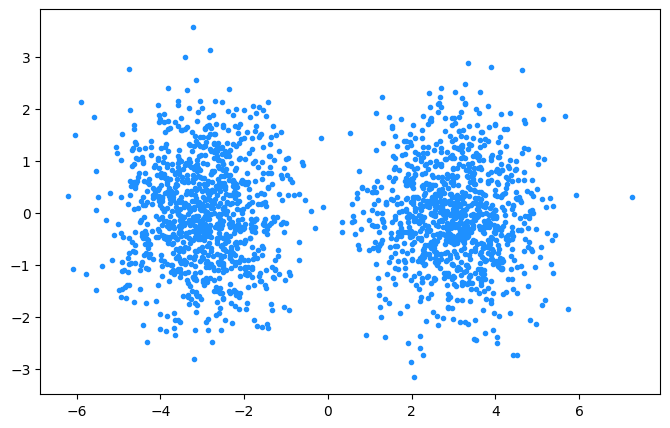

In [3]:
# Visualize the data
plt.figure(figsize=(8,5))
plt.plot(data[:,0], data[:,1], 'o', ms=3, c='dodgerblue')
plt.show()

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [4]:
class Expert(nn.Module):
  # TODO
    def __init__(self):
        super(Expert, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return self.linear(x)

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [5]:
class GatingNetwork(nn.Module):
  # TODO
  #def __init__(self, num_experts):
    def __init__(self, num_experts):
        super(GatingNetwork, self).__init__()
        self.linear = nn.Linear(2, num_experts)

    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)


## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [6]:
class MixtureOfExperts(nn.Module):
  # TODO
    def __init__(self, num_experts=2):
        super(MixtureOfExperts, self).__init__()
        self.experts = nn.ModuleList([Expert() for _ in range(num_experts)])
        self.gating_network = GatingNetwork(num_experts)

    def forward(self, x):
        expert_outputs = [expert(x) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)
        gating_probs = self.gating_network(x).unsqueeze(2)
        weighted_expert_outputs = torch.sum(gating_probs * expert_outputs, dim=1)
        return weighted_expert_outputs

## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [9]:
model = MixtureOfExperts()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

mean = data_tensor.mean(dim=0)
std = data_tensor.std(dim=0)
data_normalized = (data_tensor - mean) / std

# Training loop
num_epochs = 500
for epoch in range(num_epochs):

    outputs = model(data_normalized)
    loss = criterion(outputs, labels_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        predictions = torch.round(torch.sigmoid(outputs))
        correct_predictions = (predictions == labels_tensor).sum().item()
        total_samples = labels_tensor.size(0)
        accuracy = correct_predictions / total_samples

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/500], Loss: 0.5810, Accuracy: 0.6790
Epoch [20/500], Loss: 0.4930, Accuracy: 0.7540
Epoch [30/500], Loss: 0.3862, Accuracy: 0.8735
Epoch [40/500], Loss: 0.3199, Accuracy: 0.8830
Epoch [50/500], Loss: 0.2840, Accuracy: 0.9010
Epoch [60/500], Loss: 0.2639, Accuracy: 0.9075
Epoch [70/500], Loss: 0.2515, Accuracy: 0.9145
Epoch [80/500], Loss: 0.2433, Accuracy: 0.9160
Epoch [90/500], Loss: 0.2373, Accuracy: 0.9165
Epoch [100/500], Loss: 0.2328, Accuracy: 0.9180
Epoch [110/500], Loss: 0.2293, Accuracy: 0.9190
Epoch [120/500], Loss: 0.2264, Accuracy: 0.9220
Epoch [130/500], Loss: 0.2240, Accuracy: 0.9225
Epoch [140/500], Loss: 0.2220, Accuracy: 0.9240
Epoch [150/500], Loss: 0.2203, Accuracy: 0.9240
Epoch [160/500], Loss: 0.2188, Accuracy: 0.9245
Epoch [170/500], Loss: 0.2175, Accuracy: 0.9245
Epoch [180/500], Loss: 0.2164, Accuracy: 0.9250
Epoch [190/500], Loss: 0.2154, Accuracy: 0.9255
Epoch [200/500], Loss: 0.2145, Accuracy: 0.9255
Epoch [210/500], Loss: 0.2137, Accuracy: 0.9255
E

## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

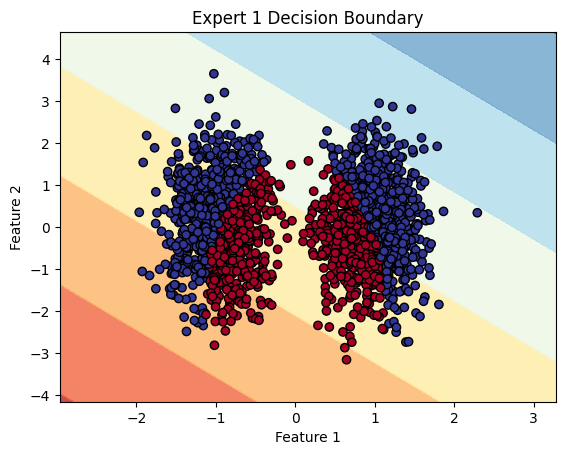

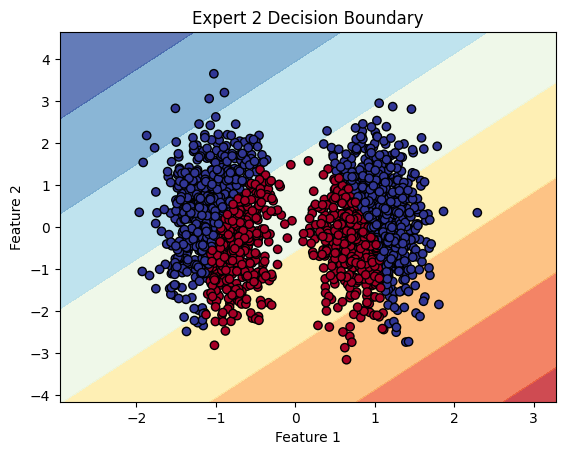

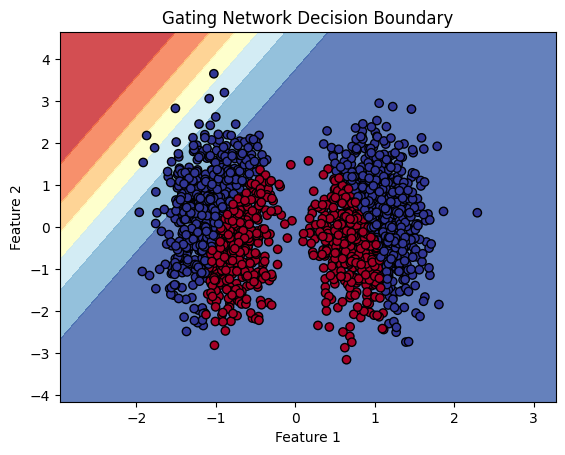

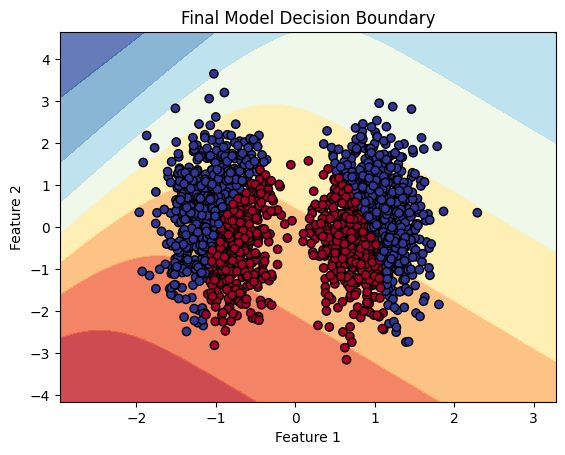

In [10]:
data_mean = data.mean(dim=0)
data_std = data.std(dim=0)

def plot_decision_boundary(model, data, labels, title):
    h = 0.02

    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_tensor = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    grid_tensor_normalized = (grid_tensor - data_mean) / data_std

    with torch.no_grad():
        Z = model(grid_tensor_normalized).numpy()

    Z = Z[:, 0]

    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdYlBu, alpha=0.8)

    plt.scatter(data[:, 0], data[:, 1], c=labels, edgecolors='k', cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

for i, expert in enumerate(model.experts):
    plot_decision_boundary(expert, data_normalized.numpy(), labels.numpy(), f'Expert {i+1} Decision Boundary')

plot_decision_boundary(model.gating_network, data_normalized.numpy(), labels.numpy(), 'Gating Network Decision Boundary')

plot_decision_boundary(model, data_normalized.numpy(), labels.numpy(), 'Final Model Decision Boundary')

Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

Individual experts capture low-level, distrinct patterns; the gating network blends the output into a model with smooth, non-linear transitions.

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)

